In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision as vision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

In [2]:
class Decoder(nn.Module):
    '''
    Decoder network
    params:
        in_channels: input channels (from vq)
        num_hidden: hidden convolution channels
        residual_inter: intermediary residual block channels
    '''
    def __init__(self, in_channels, num_hidden, residual_inter):
        super(Decoder, self).__init__()
        
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=num_hidden,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.residual1 = Residual_block(
            in_channels=num_hidden,
            hidden_inter=residual_inter,
            hidden_final=num_hidden
        )
        self.residual2 = Residual_block(
            in_channels=num_hidden,
            hidden_inter=residual_inter,
            hidden_final=num_hidden
        )
        self.transpose1 = nn.ConvTranspose2d(
            in_channels=num_hidden,
            out_channels=num_hidden//2,
            kernel_size=4,
            stride=2,
            padding=1
        )
        self.transpose2 = nn.ConvTranspose2d(
            in_channels=num_hidden//2,
            out_channels=1,
            kernel_size=4,
            stride=2,
            padding=1
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.residual1(x)
        x = self.residual2(x)
        x = self.transpose1(x)
        x = self.transpose2(x)
        return x
    
class Encoder(nn.Module):
    '''
    Encoder block
    params:
        in_channels = input channels
        num_hidden = hidden blocks for encoder convolution
        residual_inter = intermediary residual block channels
    '''
    def __init__(self, in_channels, num_hidden, residual_inter):
        super(Encoder, self).__init__()

        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=num_hidden//2,
            kernel_size=4,
            stride=2,
            padding=1
        )
        self.conv2 = nn.Conv2d(
            in_channels=num_hidden//2,
            out_channels=num_hidden,
            kernel_size=4,
            stride=2,
            padding=1
        )
        self.residual1 = Residual_block(
            in_channels=num_hidden,
            hidden_inter=residual_inter,
            hidden_final=num_hidden
        )
        self.residual2 = Residual_block(
            in_channels=num_hidden,
            hidden_inter=residual_inter,
            hidden_final=num_hidden
        )
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.residual1(x)
        x = self.residual2(x)
        return x
    

class Residual_block(nn.Module):
    '''
    Create new Residual block
    Params:
        in_channels: Input channels
        hidden_inter: hidden channels for intermediate convolution
        hidden_final: Number of channels for output convolution
    '''
    def __init__(self, in_channels, hidden_inter, hidden_final):
        super(Residual_block, self).__init__()
        self.net = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=hidden_inter,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=False
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_inter,
                out_channels=hidden_final,
                kernel_size=1,
                stride=1,
                bias=False
            )
        )

    def forward(self, x):
        # Skip connection
        return x + self.net(x)
    

import torch 
import torch.nn as nn
import torch.nn.functional as F

class VectorQuantizer(nn.Module):
    """
    Create a Vector Quantizer module
    Params:
        num_embeddings: Number of embeddings in embeddings codebook
        embedding_dim: dim of each embedding in embeddings codebook
        commitment_cost: commitment term of the loss (beta in loss function)
    """
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        self.num_embeddings = num_embeddings 
        self.embedding_dim = embedding_dim

        # Create embedding table 
        self.embedding = nn.Embedding(self.num_embeddings, self.embedding_dim)
        # the learnable weights of the module of shape (num_embeddings, embedding_dim) initialized from \mathcal{N}(0, 1)N(0,1)
        self.embedding.weight.data.uniform_(-1/self.num_embeddings, 1/self.num_embeddings)
        self.commitment_cost = commitment_cost
    
    def forward(self, x):
        # convert inputs from BCHW to BHWC
        x = x.permute(0,2,3,1).contiguous() # keep memory contiguous
        x_shape = x.shape
        # Flatten
        # Each flattened layer is individually quantized
        flat_x = x.view(-1, self.embedding_dim)
        # Calculate distances
        # Find closest codebook vectors
        # find distance of encoded vector to all coded vectors
        # shape (#,num encodings)
        distances = (torch.sum(flat_x**2, dim=1, keepdim=True) 
                    + torch.sum(self.embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_x, self.embedding.weight.t()))
        
        # Encoding

        #return val for training 
        train_indices_return = torch.argmin(distances, dim=1)
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1) # min d

        encodings = torch.zeros(encoding_indices.shape[0], self.num_embeddings, device=x.device)
        encodings.scatter_(1, encoding_indices, 1) # place in encodings (eq to keras one-hot)
 
        # Quantize and unflatten
        # Multiply encodings table with embeddings
        quantized = torch.matmul(encodings, self.embedding.weight).view(x_shape)

        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), x) # stop gradient propogation on quantized
        q_latent_loss = F.mse_loss(quantized, x.detach()) 
        loss = q_latent_loss + self.commitment_cost * e_latent_loss # loss fn (paper)
        
        quantized = x + (quantized - x).detach() # when backprop end up with x (no gradient flow for other term) 
        
        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), encodings, train_indices_return

    """
    Returns embedding corresponding to encoding index
    For one index
    """
    def get_quantized(self, x):
        encoding_indices = x.unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self.num_embeddings, device=x.device)
        encodings.scatter_(1, encoding_indices, 1)
        quantized = torch.matmul(encodings, self.embedding.weight).view(1,64,64,64)
        return quantized.permute(0,3,1,2).contiguous()
    


class VQVAE(nn.Module):
    """
    VQVAE model
    params:
        num_hiddens: Hidden blocks for encoder convolutions
        residual_inter: Intermediary residual block channels
        num_embeddings: Number of codebook embeddings
        embedding_dim: Dimensions of each embedding
        commitment_cost: loss function beta value
    """
    def __init__(self, num_hiddens, residual_inter, 
                 num_embeddings, embedding_dim, commitment_cost):
        super(VQVAE, self).__init__()
        
        # Create the encoder
        self.encoder = Encoder(
            in_channels=1,
            num_hidden=num_hiddens, 
            residual_inter=residual_inter
        )

        # initial conv Convert input dimensions to embedding dimension
        self.conv1 = nn.Conv2d(
            in_channels=num_hiddens,
            out_channels=embedding_dim,
            kernel_size=1,
            stride=1
        )
       
        # Create vector qunatizer
        self.vq = VectorQuantizer(
            num_embeddings=num_embeddings, 
            embedding_dim=embedding_dim,
            commitment_cost=commitment_cost
        )
        
        # Create decoder
        self.decoder = Decoder(
            in_channels=embedding_dim,
            num_hidden=num_hiddens,
            residual_inter=residual_inter)

    def forward(self, x):
        # encode
        z = self.encoder(x)
        # change channel dim
        z = self.conv1(z)
        loss, quantized, _, _ = self.vq(z)
        # decode
        x_recon = self.decoder(quantized) # reconstructed

        return loss, x_recon

In [3]:
BATCH_SIZE = 32
EPOCHS = 20
LR = 1e-3
DEVICE = 'cuda'
NUM_HIDDENS = 128 # hidden blocks for encoder convolution 
RESIDUAL_INTER = 32 # intermediary residual block channels
NUM_EMBEDDINGS = 512 # number of embeddings for codebook
EMBEDDING_DIM = 64 # dimension of each embedding
COMMITMENT_COST = 0.25 # beta term in loss function
TRAIN_DATA_PATH = '/home/Student/s4606685/summer_research/oasis-3/png_data' # path to training data
TEST_DATA_PATH = '/home/Student/s4606685/summer_research/oasis-3/png_data' # path to test data
DATA_VARIANCE = 0.0338 # evaluated seperately on training data

model = VQVAE(NUM_HIDDENS, RESIDUAL_INTER, NUM_EMBEDDINGS, EMBEDDING_DIM, COMMITMENT_COST)
#model.to(DEVICE)
checkpoint = torch.load('/home/Student/s4606685/vqvae_11_1/model-vqvae-epoch_51.pth.tar')
model.load_state_dict(checkpoint['save_dic'])

<All keys matched successfully>

In [4]:
transform = transforms.Compose(
    [
        transforms.Resize((256,256)),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize(
            0.5, 0.5
        ),
    ]
)

test_ds = vision.datasets.ImageFolder(TEST_DATA_PATH, transform=transform)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True)

In [5]:
x = next(enumerate(test_dl))

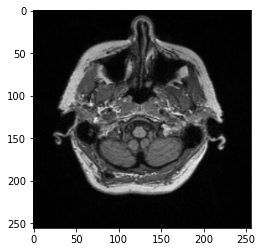

In [6]:
plt.imshow(x[1][0][1][0], cmap='gray')

In [7]:
y = model(x[1][0])

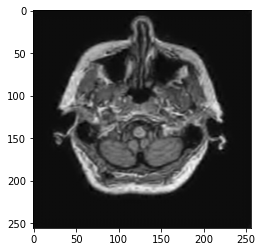

In [8]:
plt.imshow(y[1][1][0].detach(), cmap='gray')

In [9]:
F.mse_loss(y[1][1], x[1][0][1])

tensor(0.0041, grad_fn=<MseLossBackward>)

## MAP

In [9]:
def total_variation_loss(img, weight):
     bs_img, c_img, h_img, w_img = img.size()
     tv_h = torch.pow(img[:,:,1:,:]-img[:,:,:-1,:], 2).sum()
     tv_w = torch.pow(img[:,:,:,1:]-img[:,:,:,:-1], 2).sum()
     return weight*(tv_h+tv_w)/(bs_img*c_img*h_img*w_img)

# 13/1 

In [10]:
import cv2
import skimage.exposure
import os
from PIL import Image

In [11]:
# load reference image
images = os.listdir('/home/Student/s4606685/summer_research/oasis-3/png_data/T1w-png-converted')
images[50000]
ref = cv2.imread('/home/Student/s4606685/summer_research/oasis-3/png_data/T1w-png-converted/'+images[50000], cv2.IMREAD_GRAYSCALE)

In [12]:
src = cv2.imread('Image-117.png', cv2.IMREAD_GRAYSCALE)

In [13]:
matched = skimage.exposure.match_histograms(src, ref)

In [14]:
# Convert to Image
imgpil = Image.fromarray(matched)

In [15]:
from PIL import Image
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms

transform = transforms.Compose(
    [
        transforms.Resize((256,256)),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize(
            0.5, 0.5
        ),
    ]
)

#image = Image.open('Image-117.png')
image = transform(imgpil)
image = image.unsqueeze(1)
image.shape

torch.Size([1, 1, 256, 256])

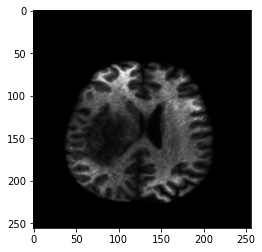

In [17]:
plt.imshow(image[0][0],cmap='gray')

In [21]:
grad.requires_grad

False

In [80]:
# Attempt on 13/1
n = 100
tv_factor = 1.6
alpha = 1

# Step 1: equalise test image (fit histogram
#Y = x[1][0][1].unsqueeze(dim=0)
Y = image

# Initialise X with equalised test img
X_im = Y
X_im.requires_grad = True

# Loop
for i in range(0,n):
    TV = total_variation_loss((X_im - Y), 1)
    loss2 = - tv_factor * TV
    vq_loss = model(X_im)
    recon = F.mse_loss(vq_loss[1], X_im) / DATA_VARIANCE
    loss1 = recon
    
    loss = loss1 + loss2
    grad = torch.autograd.grad(loss, X_im)[0]
    X_im = grad + X_im
    #X_im = X_im + alpha*grad

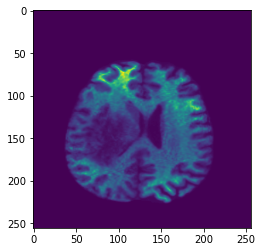

In [81]:
plt.imshow(Y[0][0].detach())

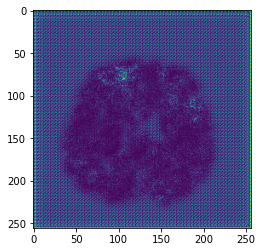

In [82]:
diff = torch.abs(Y - X_im)
plt.imshow(diff[0][0].detach())

In [25]:
torch.max(diff)

tensor(0.9059, grad_fn=<MaxBackward1>)

In [26]:
torch.min(diff)

tensor(0.0038, grad_fn=<MinBackward1>)

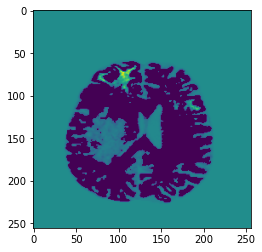

In [72]:
diff = torch.abs(Y - X_im)
diff[diff<0.3] = 0
plt.imshow(diff[0][0].detach())

In [57]:
diff

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], grad_fn=<IndexPutBackward>)

# ***

In [39]:
# Attempt on 13/1
n = 100
tv_factor = 1.6
alpha = 0.01

# Step 1: equalise test image (fit histogram)
# TODO: https://medium.com/@kyawsawhtoon/a-tutorial-to-histogram-equalization-497600f270e2
Y = x[1][0][1].unsqueeze(dim=0)

# Initialise X with equalised test img
X_im = Y
X_im.requires_grad = True

# Loop
for i in range(0,n):
    TV = total_variation_loss((X_im - Y), 1)
    loss2 = - tv_factor * TV
    vq_loss = model(X_im)
    recon = F.mse_loss(vq_loss[1], X_im) / DATA_VARIANCE
    loss1 = -1 * (vq_loss[0]+recon)
    
    loss = loss1 + loss2
    grad = torch.autograd.grad(loss, X_im)[0]
    X_im = X_im + alpha*grad

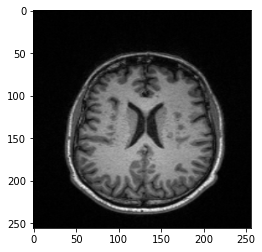

In [40]:
plt.imshow(X_im[0][0].detach(), cmap='gray')

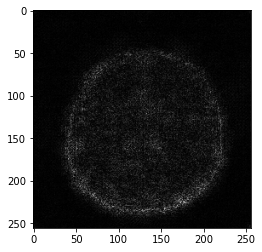

In [41]:
diff = torch.abs(Y - X_im)
plt.imshow(diff[0][0].detach(), cmap='gray')

In [18]:
from PIL import Image
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms

transform = transforms.Compose(
    [
        transforms.Resize((256,256)),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize(
            0.5, 0.5
        ),
    ]
)

image = Image.open('Image-117.png')
image = transform(image)
image = image.unsqueeze(1)
image.shape

torch.Size([1, 1, 256, 256])

In [19]:
# Attempt on 13/1
n = 100
tv_factor = 1.6
alpha = 0.01

# Step 1: equalise test image (fit histogram)
# TODO:
Y = image

# Initialise X with equalised test img
X_im = Y
X_im.requires_grad = True

# Loop
for i in range(0,n):
    TV = total_variation_loss((X_im - Y), 1)
    loss2 = - tv_factor * TV
    vq_loss = model(X_im)
    recon = F.mse_loss(vq_loss[1], X_im) / DATA_VARIANCE
    loss1 = -1 * (vq_loss[0]+recon)
    
    loss = loss1 + loss2
    grad = torch.autograd.grad(loss, X_im)[0]
    X_im = X_im + alpha*grad

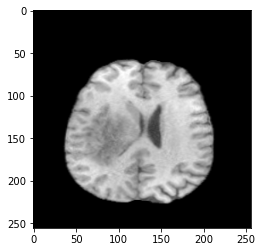

In [20]:
plt.imshow(image[0][0].detach(), cmap='gray')

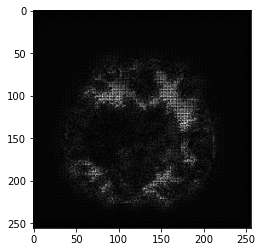

In [29]:
diff = torch.abs(Y - X_im)
plt.imshow(diff[0][0].detach(), cmap='gray')

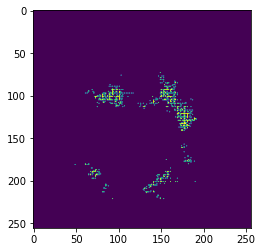

In [31]:
diff[diff<0.0005] = 0
diff[diff>0.0005] = 1
plt.imshow(diff[0][0].detach())


## 13/1 ENDS HERE

In [12]:
Y.requires_grad

False

In [22]:
# Single iter
'''
X_im = x[1][0][1].unsqueeze(dim=0)
Y = x[1][0][1].unsqueeze(dim=0)

TV = total_variation_loss((X_im- Y), 1)
loss2 = - 5 * TV # rho == 5 to be optimized

vq_loss = model(X_im) # not considering reconstruction loss
recon = F.mse_loss(vq_loss[1], X_im) / DATA_VARIANCE
loss1 = -1 * (vq_loss[0] + recon)

loss = loss1 + loss2

# Get gradient
grad = torch.autograd.grad(loss, vq_loss[1])[0]
X_im = vq_loss[1] + 0.001*grad

for n in range(100):
    TV = total_variation_loss((X_im- Y), 1)
    loss2 = - 5 * TV # rho == 5 to be optimized

    vq_loss = model(X_im) # not considering reconstruction loss
    recon = F.mse_loss(vq_loss[1], X_im) / DATA_VARIANCE
    loss1 = -1 * (vq_loss[0] + recon)

    loss = loss1 + loss2

    # Get gradient
    grad = torch.autograd.grad(loss, X_im)[0]
    X_im = X_im + 0.001*grad

'''
X_im = x[1][0][1].unsqueeze(dim=0)
Y = x[1][0][1].unsqueeze(dim=0)
X_im.requires_grad = True
TV = total_variation_loss((X_im - Y), 1)
loss2 = - 5 * TV # rho == 5 to be optimized

vq_loss = model(X_im) # not considering reconstruction loss
recon = F.mse_loss(vq_loss[1], X_im) / DATA_VARIANCE
loss1 = -1 * (vq_loss[0] + recon)

loss = loss1 + loss2

# Get gradient
grad = torch.autograd.grad(loss, X_im)[0]
X_im = vq_loss[1] + 0.001*grad

for n in range(100):
    TV = total_variation_loss((X_im- Y), 1)
    print(TV)
    loss2 = - 5 * TV # rho == 5 to be optimized

    vq_loss = model(X_im) # not considering reconstruction loss
    recon = F.mse_loss(vq_loss[1], X_im) / DATA_VARIANCE
    loss1 = -1 * (vq_loss[0] + recon)

    loss = loss1 + loss2

    # Get gradient
    grad = torch.autograd.grad(loss, X_im)[0]
    X_im = X_im + 1*grad


tensor(0.0071, grad_fn=<DivBackward0>)
tensor(0.0071, grad_fn=<DivBackward0>)
tensor(0.0071, grad_fn=<DivBackward0>)
tensor(0.0071, grad_fn=<DivBackward0>)
tensor(0.0071, grad_fn=<DivBackward0>)
tensor(0.0071, grad_fn=<DivBackward0>)
tensor(0.0070, grad_fn=<DivBackward0>)
tensor(0.0070, grad_fn=<DivBackward0>)
tensor(0.0070, grad_fn=<DivBackward0>)
tensor(0.0070, grad_fn=<DivBackward0>)
tensor(0.0070, grad_fn=<DivBackward0>)
tensor(0.0070, grad_fn=<DivBackward0>)
tensor(0.0070, grad_fn=<DivBackward0>)
tensor(0.0070, grad_fn=<DivBackward0>)
tensor(0.0070, grad_fn=<DivBackward0>)
tensor(0.0070, grad_fn=<DivBackward0>)
tensor(0.0070, grad_fn=<DivBackward0>)
tensor(0.0070, grad_fn=<DivBackward0>)
tensor(0.0070, grad_fn=<DivBackward0>)
tensor(0.0070, grad_fn=<DivBackward0>)
tensor(0.0069, grad_fn=<DivBackward0>)
tensor(0.0069, grad_fn=<DivBackward0>)
tensor(0.0069, grad_fn=<DivBackward0>)
tensor(0.0069, grad_fn=<DivBackward0>)
tensor(0.0069, grad_fn=<DivBackward0>)
tensor(0.0069, grad_fn=<D

In [23]:
X_im.requires_grad

True

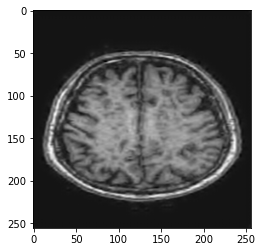

In [24]:
plt.imshow(X_im[0][0].detach(), cmap='gray')

In [25]:
diff = X_im - Y
#plt.imshow(diff[0][0].detach(), cmap='gray')

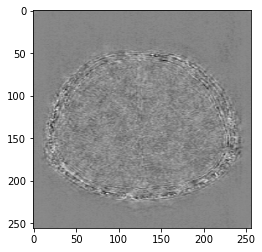

In [26]:
plt.imshow(diff[0][0].detach(), cmap='gray')

In [27]:
diff[diff<0.3] = 0

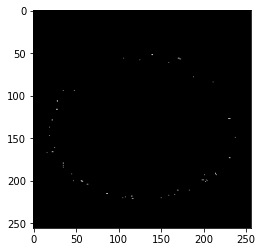

In [28]:
plt.imshow(diff[0][0].detach(),cmap='gray')

In [29]:
import os
os.listdir('.')

['model-vqvae-epoch_1.pth.tar',
 'sjobtest',
 'model-vqvae-epoch_41.pth.tar',
 'model-vqvae-epoch_31.pth.tar',
 'model-vqvae-epoch_51.pth.tar',
 'inference.ipynb',
 'model-vqvae-epoch_21.pth.tar',
 '.ipynb_checkpoints',
 'model-vqvae-epoch_11.pth.tar',
 'vqvae_train.py',
 'Image-117.png',
 'slurm-2451.out']

In [30]:
from PIL import Image
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms

transform = transforms.Compose(
    [
        transforms.Resize((256,256)),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize(
            0.5, 0.5
        ),
    ]
)

image = Image.open('Image-117.png')


In [31]:
image = transform(image)

In [32]:
image = image.unsqueeze(1)

In [33]:
image.shape

torch.Size([1, 1, 256, 256])

In [27]:
X_im = image
Y = image

TV = total_variation_loss((X_im- Y), 1)
loss2 = - 5 * TV # rho == 5 to be optimized

vq_loss = model(X_im) # not considering reconstruction loss
recon = F.mse_loss(vq_loss[1], X_im) / DATA_VARIANCE
loss1 = -1 * (vq_loss[0] + recon)

loss = loss1 + loss2

# Get gradient
grad = torch.autograd.grad(loss, vq_loss[1])[0]
X_im = vq_loss[1] + 0.001*grad

for n in range(100):
    TV = total_variation_loss((X_im- Y), 1)
    loss2 = - 5 * TV # rho == 5 to be optimized

    vq_loss = model(X_im) # not considering reconstruction loss
    recon = F.mse_loss(vq_loss[1], X_im) / DATA_VARIANCE
    loss1 = -1 * (vq_loss[0] + recon)

    loss = loss1 + loss2

    # Get gradient
    grad = torch.autograd.grad(loss, X_im)[0]
    X_im = X_im + 0.001*grad

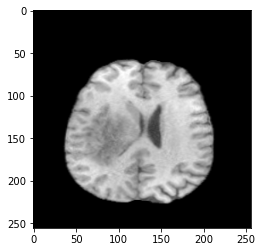

In [31]:
plt.imshow(image[0][0].detach(), cmap='gray')

In [58]:
diff = X_im - Y

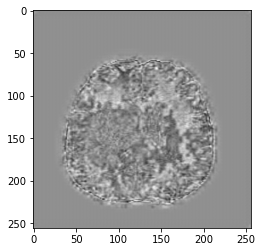

In [59]:
plt.imshow(diff[0][0].detach(), cmap='gray')

In [93]:
torch.min(diff), torch.max(diff)

(tensor(-0.3849, grad_fn=<MinBackward1>),
 tensor(0.3260, grad_fn=<MaxBackward1>))

In [61]:
diff[diff>0.1] = 1

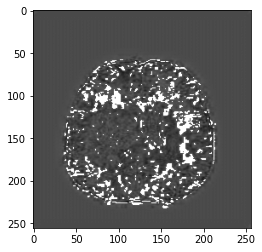

In [62]:
plt.imshow(diff[0][0].detach(), cmap='gray')

In [34]:
X_im = image
Y = image
X_im.requires_grad=True

TV = total_variation_loss((X_im- Y), 1)
loss2 = - 5 * TV # rho == 5 to be optimized

vq_loss = model(X_im) # not considering reconstruction loss
recon = F.mse_loss(vq_loss[1], X_im) / DATA_VARIANCE
loss1 = -1 * (vq_loss[0] + recon)

loss = loss1 + loss2

# Get gradient
grad = torch.autograd.grad(loss, X_im)[0]
print(grad)
X_im = vq_loss[1] + 0.001*grad

for n in range(500):
    TV = total_variation_loss((X_im- Y), 1)
    loss2 = - 5 * TV # rho == 5 to be optimized

    vq_loss = model(X_im) # not considering reconstruction loss
    recon = F.mse_loss(vq_loss[1], X_im) / DATA_VARIANCE
    loss1 = -1 * (vq_loss[0] + recon)

    loss = loss1 + loss2

    # Get gradient
    grad = torch.autograd.grad(loss, X_im)[0]
    X_im = X_im + 1*grad

tensor([[[[ 4.3881e-05,  2.8693e-05,  1.5601e-05,  ...,  1.8846e-05,
            2.9021e-05,  6.7756e-05],
          [ 3.3534e-05,  2.0325e-05,  8.3887e-06,  ...,  9.8991e-06,
            5.0767e-05,  2.4794e-05],
          [ 1.9490e-05,  4.5623e-05,  2.8510e-05,  ...,  9.7798e-06,
            3.3633e-05,  5.6549e-05],
          ...,
          [ 8.4378e-06,  9.5955e-06, -1.5053e-05,  ..., -6.1472e-06,
            7.8093e-05,  5.6445e-05],
          [-2.8726e-05,  9.9435e-06,  3.0528e-05,  ...,  2.3248e-05,
            7.9477e-05,  3.6598e-05],
          [ 1.8591e-05,  5.0449e-05,  6.3258e-05,  ...,  5.5854e-05,
            6.5935e-05,  5.2034e-05]]]])


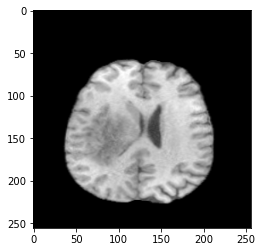

In [35]:
plt.imshow(image[0][0].detach(), cmap='gray')

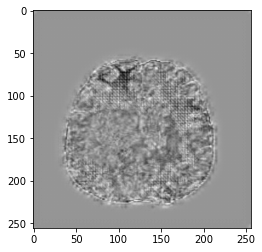

In [45]:
diff = X_im - Y
plt.imshow(diff[0][0].detach(), cmap='gray')

In [46]:
torch.min(diff)

tensor(-0.3858, grad_fn=<MinBackward1>)

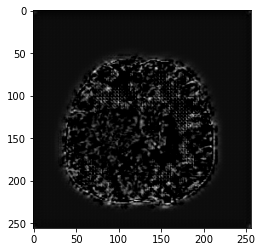

In [47]:
diff[diff<0] = 0
plt.imshow(diff[0][0].detach(), cmap='gray')

In [48]:
X_im = image
Y = image
X_im.requires_grad=True

TV = total_variation_loss((X_im- Y), 1)
loss2 = - 5 * TV # rho == 5 to be optimized

vq_loss = model(X_im) # not considering reconstruction loss
recon = F.mse_loss(vq_loss[1], X_im) / DATA_VARIANCE
loss1 = -1 * (vq_loss[0] + recon)

loss = loss1 + loss2

In [49]:
torch.autograd.grad(loss, X_im)

(tensor([[[[ 4.3881e-05,  2.8693e-05,  1.5601e-05,  ...,  1.8846e-05,
             2.9021e-05,  6.7756e-05],
           [ 3.3534e-05,  2.0325e-05,  8.3887e-06,  ...,  9.8991e-06,
             5.0767e-05,  2.4794e-05],
           [ 1.9490e-05,  4.5623e-05,  2.8510e-05,  ...,  9.7798e-06,
             3.3633e-05,  5.6549e-05],
           ...,
           [ 8.4378e-06,  9.5955e-06, -1.5053e-05,  ..., -6.1472e-06,
             7.8093e-05,  5.6445e-05],
           [-2.8726e-05,  9.9435e-06,  3.0528e-05,  ...,  2.3248e-05,
             7.9477e-05,  3.6598e-05],
           [ 1.8591e-05,  5.0449e-05,  6.3258e-05,  ...,  5.5854e-05,
             6.5935e-05,  5.2034e-05]]]]),)